In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 9.7 MB/s 
     |████████████████████████████████| 186 kB 58.9 MB/s 
     |████████████████████████████████| 46 kB 2.7 MB/s 
     |████████████████████████████████| 1.2 MB 40.9 MB/s 
     |████████████████████████████████| 56 kB 2.7 MB/s 
     |████████████████████████████████| 51 kB 278 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [4]:
Path.BASE_PATH = path
path

Path('.')

In [5]:
# get the dataframe containing information from the dataset
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [6]:
# make functions to get x and y from the df
def get_y(row):
  return row['labels'].split(' ')

def get_x(row):
  return path/'train'/row['fname']

row_1 = df.iloc[0]
row_1

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [7]:
get_x(row_1), get_y(row_1)

(Path('train/000005.jpg'), ['chair'])

In [8]:
# create a splitting function based on the validation label
def split(df):
  train = df.index[df['is_valid']].to_list()
  valid = df.iloc[~df.index.isin(train)].index.to_list()
  return train, valid

In [9]:
split(df)[0][:10], split(df)[1][:10]

([0, 1, 2, 4, 6, 7, 8, 10, 12, 18], [3, 5, 9, 11, 13, 14, 15, 16, 17, 20])

In [10]:
# create a data block that uses get_x, get_y, and splitter for multilabel cat
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=split)

dsets = dblock.datasets(df)

dsets.train[0][0], dsets.train.vocab[torch.where(dsets.train[0][1]==1)[0]]

(PILImage mode=RGB size=500x375, (#1) ['chair'])

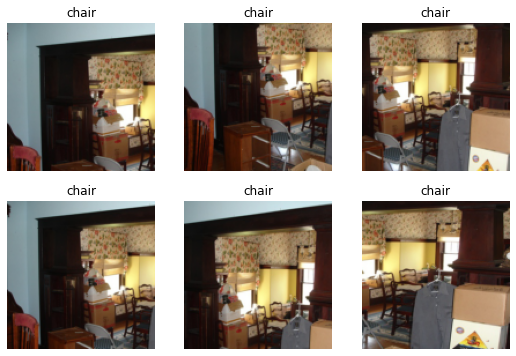

In [11]:
# seems to be working, now create a dataloader to finish it up
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=split,
                   item_tfms = RandomResizedCrop(size=128, min_scale=0.35))

dls = dblock.dataloaders(df)
dls.show_batch(unique=True, nrows=2, ncols = 3)

## Binary CE Loss

In [12]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
# get the activations from the final layer of the model
x, y = to_cpu(dls.train.one_batch())
x.shape, y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 20]))

In [14]:
# get the activaitons for the final layer
act = learn.model(x)
act.shape, act[0]

(torch.Size([64, 20]),
 tensor([ 0.7728, -0.3876, -2.2338,  1.4567, -1.4049,  0.2376,  0.7558,  2.4152, -1.3894,  1.7444, -1.6698,  0.8239,  2.0621, -4.1190, -2.4645, -1.8777,  0.5825,  3.3500,  4.4467, -0.8000],
        grad_fn=<SelectBackward>))

In [15]:
# create BCE loss from these activations
def manual_bce_loss(acts, targ):
  acts = acts.sigmoid()
  return -torch.where(targ == 1, acts, 1-acts).log().mean()

manual_bce_loss(act, y), nn.BCEWithLogitsLoss()(act, y)

(TensorMultiCategory(1.0804, grad_fn=<AliasBackward>),
 TensorMultiCategory(1.0804, grad_fn=<AliasBackward>))

In [16]:
learn = cnn_learner(dls, resnet34, metrics=partial(accuracy_multi, thresh=0.4), loss_func=manual_bce_loss)
# should fine lr here to pass into base lr then unfreeze model, find lr again and train for more epochs
# use this approach here just to be simplistic
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.987209,0.727831,0.443283,00:37
1,0.871480,0.562162,0.568793,00:36
2,0.643921,0.209878,0.935546,00:37
3,0.386870,0.136791,0.951999,00:37


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.145354,0.127657,0.954698,00:38
1,0.128214,0.118741,0.957917,00:39
2,0.109572,0.112314,0.959656,00:39


In [20]:
# see if we can pick a threshold hyperparamter 
preds, targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.7, sigmoid=True)

TensorBase(0.9582)

In [22]:
# look at the predictions to see if they have had sigmoid applied
preds[0]

tensor([-5.3688, -5.0603, -4.6711, -4.4023, -4.5680, -0.1942,  0.6232, -4.3563, -4.4947, -5.2166, -5.8358, -4.3501, -6.1325, -4.7078, -0.4547, -5.3213, -5.2378, -4.4150, -3.2977, -3.5088])

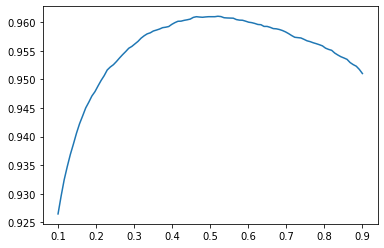

In [23]:
poss_thresh = torch.linspace(0.1,0.9,100)
accs = [accuracy_multi(preds, targs, thresh=thresh) for thresh in poss_thresh]
plt.plot(poss_thresh, accs)

- We can use the validation set to tune this hyperparameter since there is a smooth relationship. Choose thesh = 0.5 for optimal results

## Regression

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [25]:
Path.BASE_PATH = path

In [5]:
# look inside the path to see how the data is structured
path.ls()

(#50) [Path('16.obj'),Path('24'),Path('01.obj'),Path('07'),Path('06.obj'),Path('03.obj'),Path('06'),Path('16'),Path('08'),Path('12.obj')...]

In [6]:
(path/'24').ls()

(#986) [Path('24/frame_00117_rgb.jpg'),Path('24/frame_00263_rgb.jpg'),Path('24/frame_00315_pose.txt'),Path('24/frame_00328_pose.txt'),Path('24/frame_00583_pose.txt'),Path('24/frame_00319_rgb.jpg'),Path('24/frame_00190_rgb.jpg'),Path('24/frame_00607_pose.txt'),Path('24/frame_00192_pose.txt'),Path('24/frame_00008_rgb.jpg')...]

In [7]:
file_1 = open(path/'24'/'frame_00315_pose.txt', 'r')
# while file_1.newlines():
print(file_1.readlines())

['0.996403 -0.0330692 0.0780167 \n', '-0.0165185 0.827236 0.561612 \n', '-0.0831102 -0.560881 0.823714 \n', '\n', '126.078 -8.42619 972.955 \n', '\n']


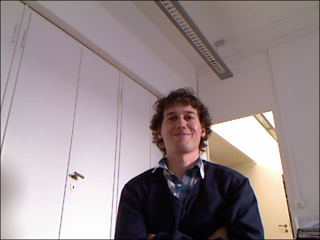

In [12]:
# get the image files
im_files = get_image_files(path)
im = PILImage.create(im_files[0])
im.to_thumb(320)

In [27]:
str(im_files[0])

'/root/.fastai/data/biwi_head_pose/24/frame_00117_rgb.jpg'

In [32]:
def img_to_pose(im):
  base_str = " ".join(re.findall(r'(.+_\d+_)rgb\.jpg$', str(im)))
  return base_str + "pose.txt"

img_to_pose(im_files[0])

'/root/.fastai/data/biwi_head_pose/24/frame_00117_pose.txt'

In [34]:
# use a premade method to get the centre of the image
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img_to_pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

get_ctr(im_files[0])

tensor([383.0029, 241.6483])

In [37]:
im_files[0].parent.name

'24'

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


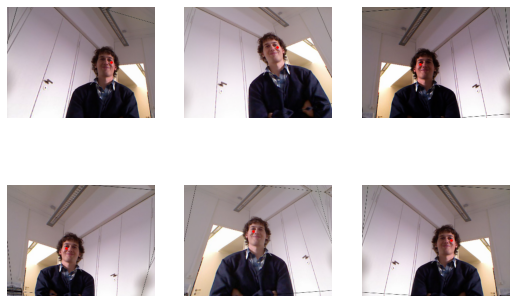

In [38]:
# create a dataloader
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter=FuncSplitter(lambda im_path: im_path.parent.name == '13'),
    batch_tfms=aug_transforms(size=(240, 320))
)

dls = biwi.dataloaders(path)
dls.show_batch(max_n = 6, unique=True)

In [39]:
# create a learner which scales predicitons from -1 to 1 so that all predictions are inside the image
learn = cnn_learner(dls, resnet18, y_range=(-1, 1))
dls.loss_func

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0010000000474974513)

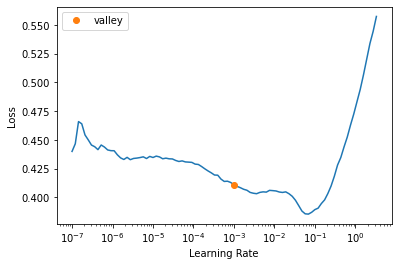

In [41]:
learn.lr_find()

In [43]:
# fit one cycle for the corresponding lr (layers are frozen). Lowest value is about 5e-2, so choose 5e-3
learn.fit_one_cycle(4, 5e-3)

epoch,train_loss,valid_loss,time
0,0.054076,0.001513,01:58
1,0.012636,0.002882,01:57
2,0.006117,0.003681,01:58
3,0.003867,0.001301,01:58


SuggestedLRs(valley=6.30957365501672e-05)

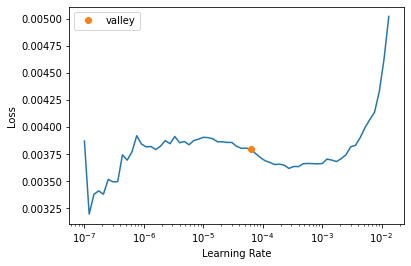

In [44]:
learn.unfreeze()
learn.lr_find()

In [46]:
learn.fit_one_cycle(3, lr_max=slice(6e-7, 6e-5))

epoch,train_loss,valid_loss,time
0,0.003458,0.001127,02:07
1,0.002862,0.000886,02:08
2,0.002805,0.000971,02:08


In [48]:
# find the loss as a distance by square rooting the final validation loss
final_loss = math.sqrt(0.000971)
final_loss

0.031160872901765765

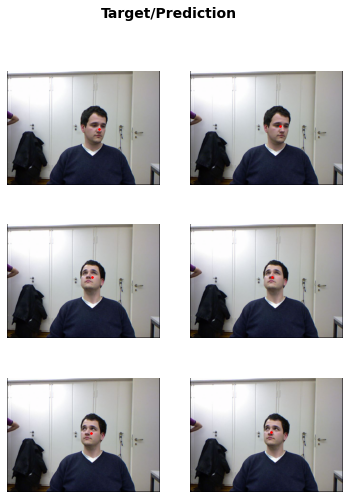

In [49]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))